<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac,non_negative_parafac
import tensorly as tl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq
from tensorly.cp_tensor import cp_to_tensor
from sklearn.metrics import accuracy_score, log_loss
import time
from datetime import datetime
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import torch
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc,
                           accuracy_score, precision_score, recall_score, f1_score,
                           ConfusionMatrixDisplay)
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [3]:
pip install tensorly

"""
This pipeline is designed to detect anomalies in network traffic using a tensor-based deep learning approach.

Steps and Objectives:
---------------------
1. **Preprocessing & Tensor Construction**:
   - Multivariate network traffic data is aggregated over time windows.
   - A 4D tensor is built with dimensions: [Time_Window, Src IP, Dst IP,featues].

2. **Tensor Decomposition (CP)**:
   - The tensor is decomposed using CP (CANDECOMP/PARAFAC) to extract the underlying structure (normal behavior).
   - This reveals low-rank patterns, which capture typical traffic patterns.

3. **Reconstruction & Residual Calculation**:
   - We take the training tenssor and we compute its CP decomposition
   - Residuals are computed as the difference between the measure of the train tensor and the projection of this measure in the latent space.
4. **Anomaly Scoring**:
Since our goal aim to detect DDoS and DOS attack so:
   - Scores are aggregated per destination IP (`Dst IP`) and feature.
   - These scores reflect the degree of deviation from normal patterns.

5. **Deep Learning Classification**:
   - The aggregated anomaly scores are used as input to a neural network.
   - If labeled data is available, the model is trained in a supervised way to classify normal vs anomalous flows.
   - If labels are absent, an autoencoder is trained to learn normal behavior and detect deviations.

6. **Prediction**:
   - New traffic data is processed through the same pipeline.
   - The trained model predicts anomaly scores or binary classifications.

Main Goal:
----------
To detect abnormal network behavior in the IOT_data  by modeling traffic patterns as tensors, identifying deviations, and classifying them using deep learning models.
"""


In [5]:
warnings.filterwarnings("ignore")

In [6]:
tl.set_backend('pytorch')

In [7]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define the dataset**

In [9]:
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic.pcap_Flow.csv')
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic1.pcap_Flow.csv')
df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-HTTP_Flood.pcap_Flow.csv')
df7=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-HTTP_Flood1.pcap_Flow.csv')

In [10]:
df1['label']=0
df2['label']=0
df3['label']=0
df4['label']=0
df5['label']=1
df6['label']=1
df7['label']=1

In [11]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df6.replace([np.inf, -np.inf], np.nan, inplace=True)
df7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Drop na
for df in [df1,df2,df3,df4,df5,df6,df7]:
    r=df.isna().sum()
    print("nan for :are :",r[r>0])

nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      45
Flow Packets/s    45
dtype: int64
nan for :are : Flow Bytes/s      17
Flow Packets/s    17
dtype: int64
nan for :are : Flow Bytes/s      1123
Flow Packets/s    1123
dtype: int64
nan for :are : Flow Bytes/s      40786
Flow Packets/s    40786
dtype: int64
nan for :are : Flow Bytes/s      38735
Flow Packets/s    38735
dtype: int64


In [ ]:
#Shape of each dataset
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)

(183630, 85)
(84526, 85)
(91279, 85)
(38895, 85)
(505720, 85)
(932513, 85)
(710231, 85)


In [12]:
#Drop duplicated rows
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)
df6.drop_duplicates(inplace=True)
df7.drop_duplicates(inplace=True)

In [13]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)
df6.dropna(inplace=True)
df7.dropna(inplace=True)

In [16]:
#Convert timestamp
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])
df7['Timestamp']=pd.to_datetime(df7['Timestamp'])

In [17]:
#Extract days
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date
df7['Jour']=df7['Timestamp'].dt.date

In [18]:
#Convert days
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])
df7['Jour']=pd.to_datetime(df7['Jour'])

In [19]:
df5_day_1=df5[df5['Jour']=='2022-09-14']
df5_day_2=df5[df5['Jour']=='2022-11-07']
df6_day_1=df6[df6['Jour']=='2022-08-08']
df6_day_2=df6[df6['Jour']=='2022-09-08']

In [20]:
#Extract time
df1['Heure']=df1['Timestamp'].dt.strftime('%H:%M:%S')
df2['Heure']=df2['Timestamp'].dt.strftime('%H:%M:%S')
df3['Heure']=df3['Timestamp'].dt.strftime('%H:%M:%S')
df4['Heure']=df4['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df7['Heure']=df7['Timestamp'].dt.strftime('%H:%M:%S')

In [21]:
#Create a relative time
df1['relative_time']=df1['Timestamp']-df1['Timestamp'].min()
df2['relative_time']=df2['Timestamp']-df2['Timestamp'].min()
df3['relative_time']=df3['Timestamp']-df3['Timestamp'].min()
df4['relative_time']=df4['Timestamp']-df4['Timestamp'].min()
df5_day_1['relative_time']=df5_day_1['Timestamp']-df5_day_1['Timestamp'].min()
df5_day_2['relative_time']=df5_day_2['Timestamp']-df5_day_2['Timestamp'].min()
df6_day_1['relative_time']=df6_day_1['Timestamp']-df6_day_1['Timestamp'].min()
df6_day_2['relative_time']=df6_day_2['Timestamp']-df6_day_2['Timestamp'].min()
df7['relative_time']=df7['Timestamp']-df7['Timestamp'].min()

In [22]:
#Normal filter
hours = df1['relative_time'].dt.total_seconds() / 3600
mask_3h = hours <= 1
df_3h = df1[mask_3h]
#Train filter
hours_t = df4['relative_time'].dt.total_seconds() / 3600
mask_3h_t = hours_t <= 1
df_3h_t = df4[mask_3h_t]
#Test filter
hours_3h_test = df3['relative_time'].dt.total_seconds() / 3600
mask_3h_test = hours_3h_test <= 1
df_3h_test = df3[mask_3h_test]
#Anomalous filter
hours_3h_test_a = df5_day_2['relative_time'].dt.total_seconds() / 3600
mask_3h_test_a = hours_3h_test_a <= 1
df_3h_test_a = df5_day_2[mask_3h_test_a]
df7_2h=df7[df7['relative_time']<pd.Timedelta(hours=1)]

# DATA CONSTRUCTION

In [23]:
#Consider for as normal_data "Benign 1 ":
df_normal=df_3h
#Training data:
df_train=pd.concat([df_3h_t,df5_day_1,df7_2h],axis=0)
df_test=pd.concat([df_3h_test,df_3h_test_a,df6_day_2],axis=0)

In [24]:
scale=StandardScaler().fit(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

In [25]:
# Original code for scaling and creating new dataframes
df_normal_scaled=scale.transform(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_train_scaled=scale.transform(df_train[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_test_scaled=scale.transform(df_test[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

df_normal_scaled=pd.DataFrame(df_normal_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_train_scaled=pd.DataFrame(df_train_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_test_scaled=pd.DataFrame(df_test_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])

# Reset the index of the original dataframes to ensure alignment
# This creates a new default integer index
df_normal = df_normal.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Now assign the columns from the original dataframes with reset indices
df_normal_scaled[['relative_time','Src IP','Dst IP','label']]=df_normal[['relative_time','Src IP','Dst IP','label']]
df_train_scaled[['relative_time','Src IP','Dst IP','label']]=df_train[['relative_time','Src IP','Dst IP','label']]
df_test_scaled[['relative_time','Src IP','Dst IP','label']]=df_test[['relative_time','Src IP','Dst IP','label']]

In [ ]:
df_normal_scaled

,Flow Duration,Flow Packets/s,Flow Bytes/s,relative_time,Src IP,Dst IP,label
0,-0.478263,-0.081236,-0.063784,0 days 00:00:01,192.168.137.41,157.249.81.141,0
1,-0.478280,-0.081235,-0.063868,0 days 00:00:01,192.168.137.41,157.249.81.141,0
2,-0.478243,-0.081237,-0.063784,0 days 00:00:03,192.168.137.41,157.249.81.141,0
3,-0.478252,-0.081236,-0.063868,0 days 00:00:03,192.168.137.41,157.249.81.141,0
4,-0.478230,-0.081237,-0.063785,0 days 00:00:04,192.168.137.41,157.249.81.141,0
...,...,...,...,...,...,...,...
21582,-0.172796,-0.081539,-0.063934,0 days 00:49:57,192.168.137.249,192.168.137.1,0
21583,-0.478944,-0.081393,-0.063814,0 days 00:56:16,192.168.137.249,8.8.8.8,0
21584,-0.484455,-0.081180,-0.063806,0 days 00:13:34,192.168.137.224,192.168.137.1,0
21585,-0.485445,-0.080364,-0.062495,0 days 00:54:43,192.168.137.249,8.8.4.4,0


# TENSOR CONSTRUCTION

In [26]:
def build_global_ip_mappings(*dfs):
    all_src_ips = set()
    all_dst_ips = set()

    for df in dfs:
        all_src_ips.update(df['Src IP'].unique())
        all_dst_ips.update(df['Dst IP'].unique())

    src_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_src_ips))}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_dst_ips))}

    return src_ip_to_idx, dst_ip_to_idx

In [27]:
src_ip_to_idx, dst_ip_to_idx=build_global_ip_mappings(df_normal,df_train,df_test)

In [28]:
def create_graph_tensor(df, src_ip_to_idx, dst_ip_to_idx, window_size=300):
    # 1. Detect device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 2. Create time windows based on relative time
    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = np.sort(df['time_window'].unique())

    # 3. Map IPs and time windows to indices
    df['t_idx'] = pd.Categorical(df['time_window'], categories=time_windows).codes
    df['src_idx'] = df['Src IP'].map(src_ip_to_idx)
    df['dst_idx'] = df['Dst IP'].map(dst_ip_to_idx)

    # 4. Drop rows where mapping failed
    df = df.dropna(subset=['src_idx', 'dst_idx'])
    df['src_idx'] = df['src_idx'].astype(int)
    df['dst_idx'] = df['dst_idx'].astype(int)

    # 5. Aggregate statistics for each (time, src, dst) triplet
    grouped = df.groupby(['t_idx', 'src_idx', 'dst_idx'], sort=False).agg(
        count=('Flow Bytes/s', 'count'),
        bytes_sum=('Flow Bytes/s', 'sum'),
        duration_mean=('Flow Duration', 'mean'),
        pps_sum=('Flow Packets/s', 'sum')
    ).reset_index()

    # 6. Initialize tensor directly
    tensor = torch.zeros(
        (len(time_windows), len(src_ip_to_idx), len(dst_ip_to_idx), 4),
        dtype=torch.float32,
        device=device
    )

    # 7. Efficiently assign aggregated values
    t_idx = torch.tensor(grouped['t_idx'].values, dtype=torch.long, device=device)
    s_idx = torch.tensor(grouped['src_idx'].values, dtype=torch.long, device=device)
    d_idx = torch.tensor(grouped['dst_idx'].values, dtype=torch.long, device=device)

    tensor.index_put_((t_idx, s_idx, d_idx, torch.zeros_like(t_idx, dtype=torch.long)),
                      torch.tensor(grouped['count'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.ones_like(t_idx, dtype=torch.long)),
                      torch.tensor(grouped['bytes_sum'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.full_like(t_idx, 2, dtype=torch.long)),
                      torch.tensor(grouped['duration_mean'].values, dtype=torch.float32, device=device))

    tensor.index_put_((t_idx, s_idx, d_idx, torch.full_like(t_idx, 3, dtype=torch.long)),
                      torch.tensor(grouped['pps_sum'].values, dtype=torch.float32, device=device))

    print("✅ Tensor successfully created | shape:", tensor.shape)
    return tensor, time_windows


In [29]:
tensor_normal, time_normal = create_graph_tensor(df_normal_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_train, time_train = create_graph_tensor(df_train_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_test, time_test = create_graph_tensor(df_test_scaled, src_ip_to_idx, dst_ip_to_idx)

Using device: cuda
✅ Tensor successfully created | shape: torch.Size([13, 822, 1313, 4])
Using device: cuda
✅ Tensor successfully created | shape: torch.Size([12, 822, 1313, 4])
Using device: cuda
✅ Tensor successfully created | shape: torch.Size([13, 822, 1313, 4])


# Tensor Normalisation

In [ ]:
def normalize_tensor_feature(tensor, feature_index):
    # Extract the feature slice
    feature_slice = tensor[:, :, :, feature_index]

    # Calculate min and max
    min_val =tensor[:,:,:,feature_index].min() # par feature
    max_val = tensor[:,:,:,feature_index].max() # par feature

    # Apply min-max normalization
    if max_val - min_val > 0:
        normalized_slice = (feature_slice - min_val) / (max_val - min_val)
    else:
        # All values are the same
        normalized_slice = feature_slice - min_val  # results in all zeros

    # Replace the original feature with the normalized one
    tensor[:, :, :, feature_index] = normalized_slice

    return tensor


In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 0)
tensor_train = normalize_tensor_feature(tensor_train, 0)
tensor_test = normalize_tensor_feature(tensor_test, 0)

In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 1)
tensor_train = normalize_tensor_feature(tensor_train, 1)
tensor_test = normalize_tensor_feature(tensor_test, 1)

In [ ]:
tensor_normal = normalize_tensor_feature(tensor_normal, 2)
tensor_train = normalize_tensor_feature(tensor_train, 2)
tensor_test = normalize_tensor_feature(tensor_test, 2)

In [15]:
tensor_normal = normalize_tensor_feature(tensor_normal, 3)
tensor_train = normalize_tensor_feature(tensor_train, 3)
tensor_test = normalize_tensor_feature(tensor_test, 3)

NameError: name 'normalize_tensor_feature' is not defined

# COMPRESSION GRAPH

In [30]:
def Tensor_decomposition(tensor,rank):

    factors_normal = parafac(tensor_normal, rank=rank, init='random',random_state=52, n_iter_max=100,l2_reg=1e-8)
    # Reconstruction
    reconstruction = cp_to_tensor(factors_normal)
    error=tl.norm(tensor_normal-reconstruction)/tl.norm(tensor_normal)
    print("error=",error)
    print("error=",error.item())

    return factors_normal,error

**Normal Projection**

In [31]:
def normal_space_projection(tensor_input, tensor_ref):
    # Extract CP factors from reference
    _, (A_ref, B_ref, C_ref, D_ref) = tensor_ref
    rank = A_ref.shape[1]

    # Ensure tensors are on the correct device and dtype
    device = tensor_input.device
    tensor_input = tensor_input.to(torch.float32).to(device)
    B_ref = B_ref.to(torch.float32).to(device)
    C_ref = C_ref.to(torch.float32).to(device)
    D_ref = D_ref.to(torch.float32).to(device)

    # Compute Khatri-Rao product of the normalized factors
    kr_product = tl.tenalg.khatri_rao([B_ref, tl.tenalg.khatri_rao([C_ref, D_ref])]) #Sir here the shape is (IJK,rank)

    kr_pinv = torch.linalg.pinv(kr_product)  # Shape (IJK,rank)

    # Project each time slice onto the latent space
    T = tensor_input.shape[0]
    A_proj = torch.zeros((T, rank), dtype=torch.float32, device=device)

    for t in range(T):
        x_vec = tensor_input[t].reshape(1, -1)  # Shape: (1, I*J*K)
        A_proj[t] = x_vec @ kr_pinv.T  # Shape: (1, rank)

    # Reconstruct the projected tensor using lambdas_ref
    projected_tensor = cp_to_tensor((None, [A_proj, B_ref, C_ref, D_ref]))

    # Compute residual
    residual = tensor_input - projected_tensor

    print("✅ Projection completed.")
    print("Residual norm:", tl.norm(residual).item())

    return residual

# AGGREGATION_SCORING

In [32]:
def aggregation_scoring_Source(residuals, mappings, df_with_labels, window_size=300):
    print("⏳ Step 4: Aggregating scores with labels...")

    # 1. Convert relative_time to time_window (as integer)
    df_with_labels = df_with_labels.copy()
    df_with_labels['time_window'] = df_with_labels['relative_time'].astype(np.int64) // (10**9 * window_size)

    # 2. Create label mapping: (Dst IP, time_window) -> label
    label_map = {}
    for _, row in df_with_labels.iterrows():
        key = (row['Dst IP'], int(row['time_window']))
        label = int(row['label']) if pd.notnull(row['label']) else 0
        label_map[key] = max(label_map.get(key, 0), label)

    # 3. Prepare dimensions
    try:
        residuals_np = tl.to_numpy(residuals)
    except Exception as e:
        raise ValueError("Failed to convert tensor to NumPy array: {}".format(e))

    # Ensure Dst_IP mapping is indexed by index, not IP
    # This assumes mappings['Dst_IP'] is {ip: idx} and we need {idx: ip}
    idx_to_dst_ip = {idx: ip for ip, idx in mappings.get('Dst_IP', {}).items()}
    idx_to_feature = mappings.get('features_names', {})

    if not idx_to_dst_ip or not idx_to_feature:
        raise ValueError("Required mappings are missing or incomplete.")

    time_dim, _, dst_dim, feat_dim = residuals_np.shape
    time_windows = np.sort(df_with_labels['time_window'].unique()) # Use windows from df_with_labels
    time_window_to_idx = {win: idx for idx, win in enumerate(time_windows)}


    # 4. Aggregation and labeling
    aggregation = {}
    unknown_features = set()

    # Iterate through residuals dimensions
    for t_idx in range(time_dim):
         # Map tensor index back to original time window value
        original_time_window_value = None
        try:
            original_time_window_value = time_windows[t_idx]
        except IndexError:
            # This time index in the tensor doesn't correspond to a time window in the original df
            continue

        for d_idx in range(dst_dim):
            dst_ip = idx_to_dst_ip.get(d_idx)
            if dst_ip is None:
                # print(f"Warning: index {d_idx} not found in Dst_IP mappings.")
                continue

            key = (dst_ip, int(original_time_window_value)) # Use original time window value for key
            if key not in aggregation:
                aggregation[key] = {
                    'Dst IP': dst_ip,
                    'time_windows': int(original_time_window_value),
                    'count': 0,
                    'bytes': 0,
                    'packets': 0,
                    'duration': 0,
                    'label': label_map.get(key, 0) # Get label using the key
                }

            for f_idx in range(feat_dim):
                feature_name = idx_to_feature.get(f_idx, '').lower() # Use feature index to get name

                # Sum of absolute residuals across Src IP dimension
                score = np.sum(np.abs(residuals_np[t_idx, :, d_idx, f_idx]))

                if 'count' in feature_name:
                    aggregation[key]['count'] += score
                elif 'bytes' in feature_name:
                    aggregation[key]['bytes'] += score
                elif 'packets' in feature_name:
                    aggregation[key]['packets'] += score
                elif 'duration' in feature_name:
                    aggregation[key]['duration'] += score
                else:
                    unknown_features.add(feature_name)

    if unknown_features:
        print(f"🟠 Warning: the following features were not recognized and were ignored: {sorted(unknown_features)}")

    df_scores = pd.DataFrame(list(aggregation.values()))

    # Ensure 'label' column exists even if DataFrame is empty
    if df_scores.empty:
         # Define expected columns if the DataFrame is empty
        expected_cols = ['Dst IP', 'time_windows', 'count', 'bytes', 'packets', 'duration', 'label']
        df_scores = pd.DataFrame(columns=expected_cols)


    print("✅ Score aggregation + labeling completed.")

    return df_scores

In [33]:
features=['count','packets','duration','bytes']
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for col in features:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer les lignes en fonction de la colonne actuelle
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df

In [34]:
mappings={'Dst_IP':dst_ip_to_idx,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

**Deep Learning Model**

In [35]:
def build_and_train_binary_classifier(X_train, y_train, X_test, y_test, learning_rate=0.0001, batch_size=32, epochs=50):
    input_dim = X_train.shape[1]

    # Définition du modèle
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(60, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),


        layers.Dense(40, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),


        layers.Dense(20, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),


        layers.Dense(1, activation='sigmoid')

    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    # Fitting
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size, # Reduced batch size
        epochs=epochs,
        verbose=1
    )

    return model, history

**JUSTIFICATION OF THE ARCHITECTURE**

The architecture follows an Activation (ReLU) → BatchNorm → Dropout order based on empirical research showing that normalizing post-activation values can better stabilize gradient flow and reduce internal covariate shift compared to the traditional BN → ReLU approach (Ding et al., 2019). By applying BatchNorm after ReLU, the network normalizes the sparse, non-negative activations, mitigating dead neurons and improving training dynamics (fast.ai, TensorFlow Addons). Dropout is placed last to regularize the normalized activations directly, preventing extreme values and enhancing generalization (Li et al., 2019). The progressive reduction in layer width (60 → 40 → 20) and dropout rates (0.3 → 0.1) follows the "information bottleneck" principle, where higher regularization in early layers combats overfitting while later layers retain discriminative features (Rippel et al., 2015; Labach et al., 2019). This design balances stability and performance, leveraging modern insights beyond the original BatchNorm paper (Ioffe & Szegedy, 2015).

**Run The pipeline**

# TESTING PHASE


=== Rank 1 ===
error= tensor(0.3124, device='cuda:0')
error= 0.31235480308532715
✅ Projection completed.
Residual norm: 95256.578125
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.5646 - auc_1: 0.6099 - loss: 0.7508 - val_accuracy: 0.8803 - val_auc_1: 0.7551 - val_loss: 0.6087
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6828 - auc_1: 0.8557 - loss: 0.6006 - val_accuracy: 0.9718 - val_auc_1: 0.9836 - val_loss: 0.6290
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7881 - auc_1: 0.9527 - loss: 0.4848 - val_accuracy: 0.9987 - val_auc_1: 0.9918 - val_loss: 0.6569
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8593 - auc_1: 0.9791 - loss: 0.4170 - val_accuracy: 0.1227 - val_auc_1: 0.9981 - val_loss: 0.6485
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9017 - auc_1: 0.9889 - loss: 0.3610 - val_accuracy: 0.

<Figure size 600x500 with 0 Axes>

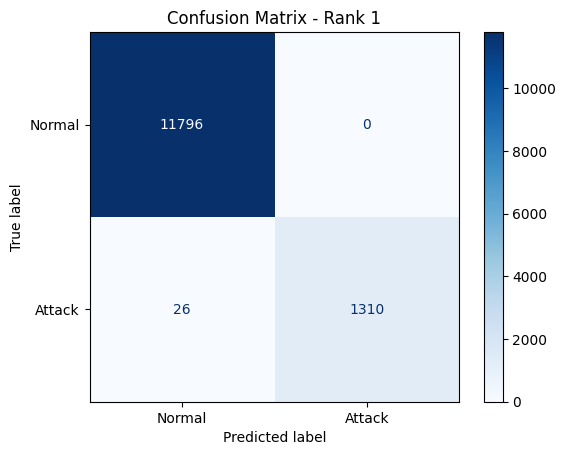

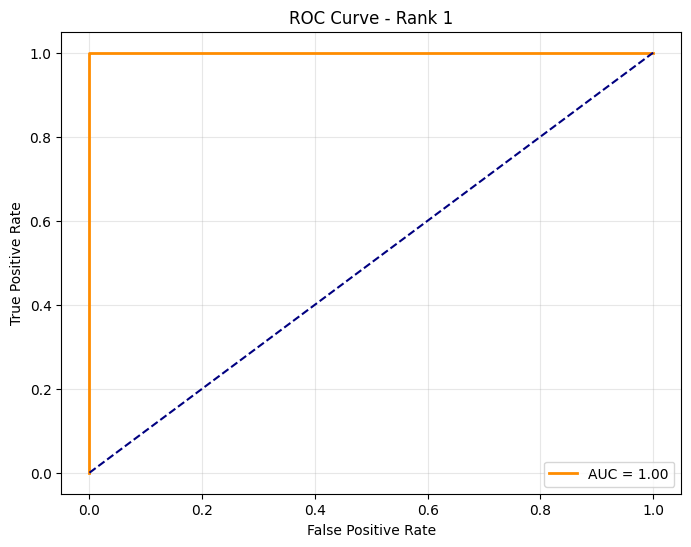

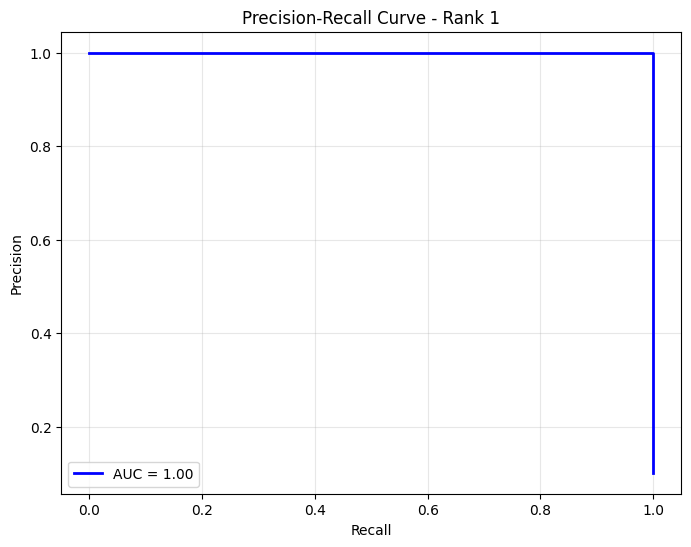


=== Rank 2 ===
error= tensor(0.2073, device='cuda:0')
error= 0.2072610706090927
✅ Projection completed.
Residual norm: 95256.4921875
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.5604 - auc_2: 0.6699 - loss: 0.7493 - val_accuracy: 0.9290 - val_auc_2: 0.9884 - val_loss: 0.6024
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7259 - auc_2: 0.9191 - loss: 0.5257 - val_accuracy: 0.9374 - val_auc_2: 1.0000 - val_loss: 0.4535
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7974 - auc_2: 0.9743 - loss: 0.4341 - val_accuracy: 0.9855 - val_auc_2: 0.9971 - val_loss: 0.3235
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8532 - auc_2: 0.9921 - loss: 0.3766 - val_accuracy: 0.9952 - val_auc_2: 0.9971 - val_loss: 0.2621
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8863 - auc_2: 0.9914 - loss: 0.3358 - val_accuracy: 0.99

<Figure size 600x500 with 0 Axes>

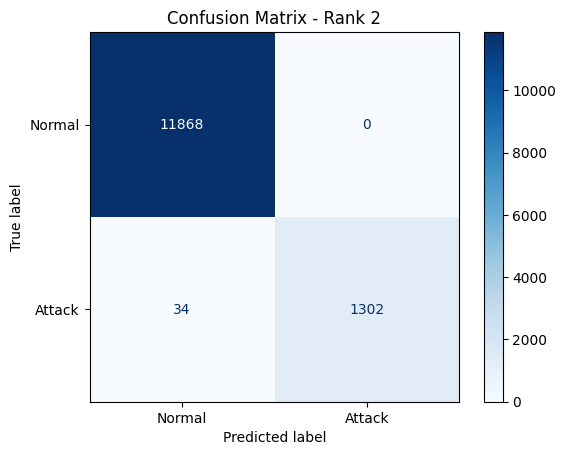

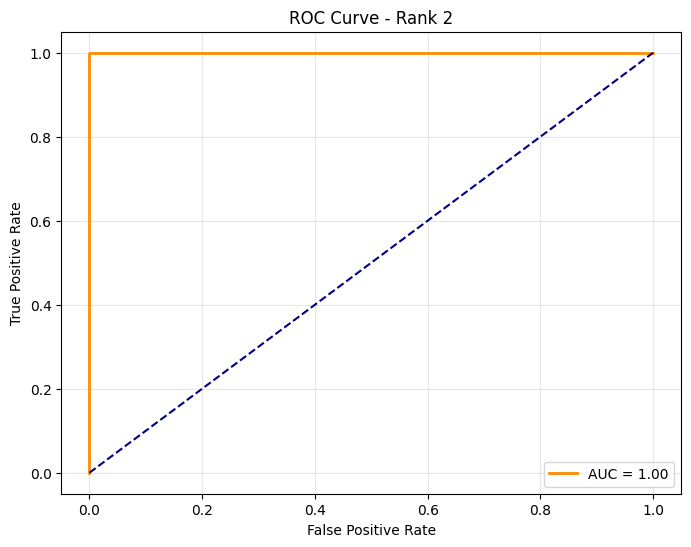

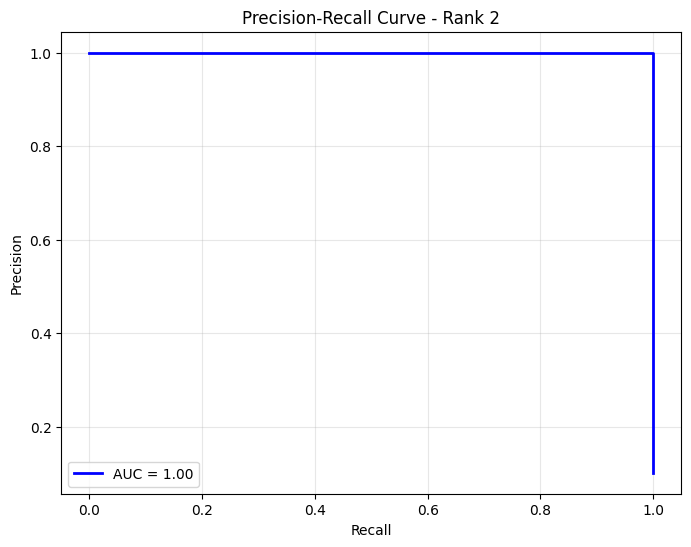


=== Rank 3 ===
error= tensor(0.1672, device='cuda:0')
error= 0.16719308495521545
✅ Projection completed.
Residual norm: 95255.9765625
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5939 - auc_3: 0.7532 - loss: 0.7147 - val_accuracy: 0.9435 - val_auc_3: 0.9990 - val_loss: 0.6270
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7132 - auc_3: 0.9258 - loss: 0.5394 - val_accuracy: 0.9889 - val_auc_3: 0.9990 - val_loss: 0.5218
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7987 - auc_3: 0.9684 - loss: 0.4443 - val_accuracy: 0.9963 - val_auc_3: 1.0000 - val_loss: 0.4386
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8578 - auc_3: 0.9792 - loss: 0.3701 - val_accuracy: 0.9980 - val_auc_3: 1.0000 - val_loss: 0.3780
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8889 - auc_3: 0.9955 - loss: 0.3257 - val_accuracy: 0.

<Figure size 600x500 with 0 Axes>

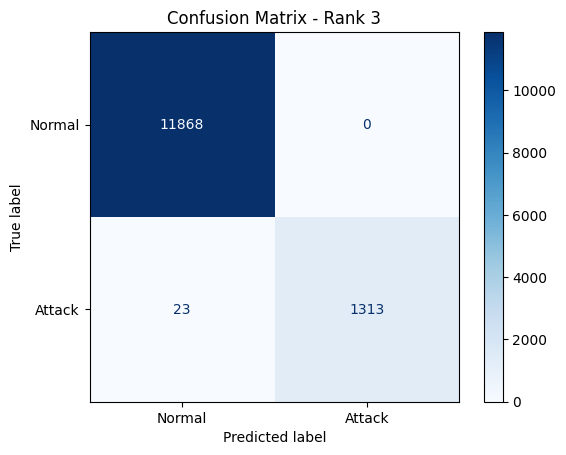

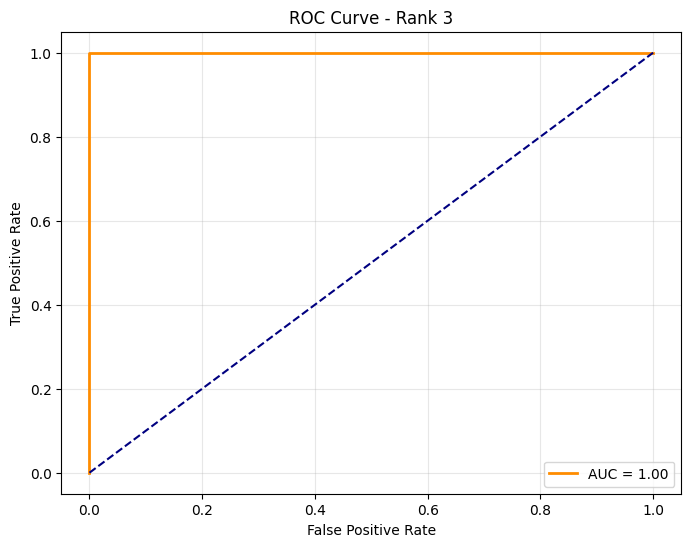

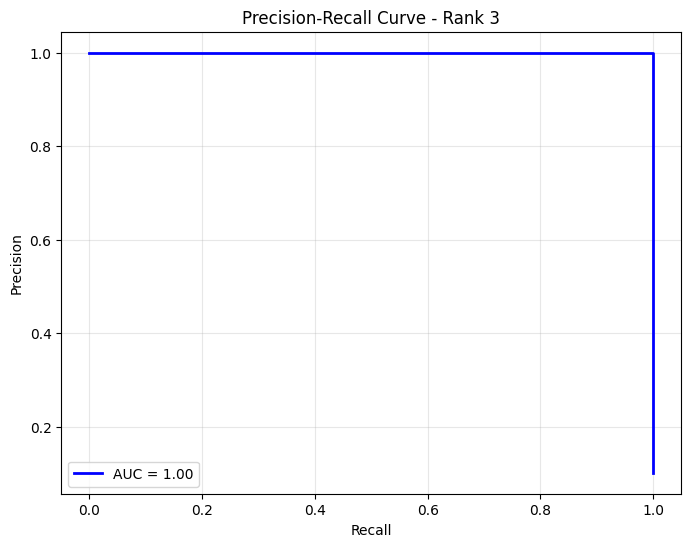


=== Rank 4 ===
error= tensor(0.1548, device='cuda:0')
error= 0.15478895604610443
✅ Projection completed.
Residual norm: 95257.8515625
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5257 - auc_4: 0.5793 - loss: 0.8352 - val_accuracy: 0.1080 - val_auc_4: 0.7908 - val_loss: 0.7999
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6722 - auc_4: 0.8396 - loss: 0.6068 - val_accuracy: 0.1142 - val_auc_4: 0.8899 - val_loss: 0.8994
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7636 - auc_4: 0.9162 - loss: 0.4956 - val_accuracy: 0.1175 - val_auc_4: 0.9372 - val_loss: 0.9543
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8296 - auc_4: 0.9558 - loss: 0.4268 - val_accuracy: 0.1191 - val_auc_4: 0.9681 - val_loss: 0.8940
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8634 - auc_4: 0.9764 - loss: 0.3771 - val_accuracy: 0.1

<Figure size 600x500 with 0 Axes>

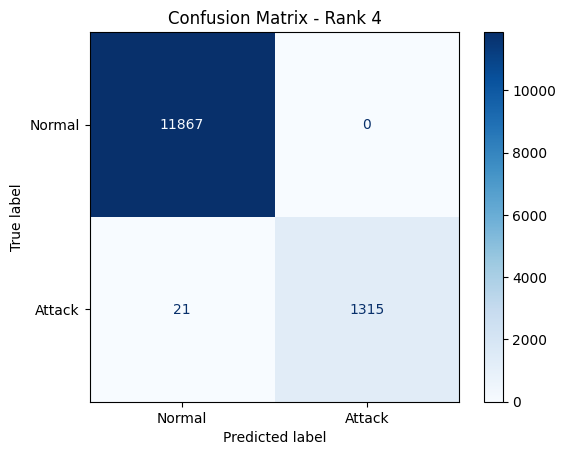

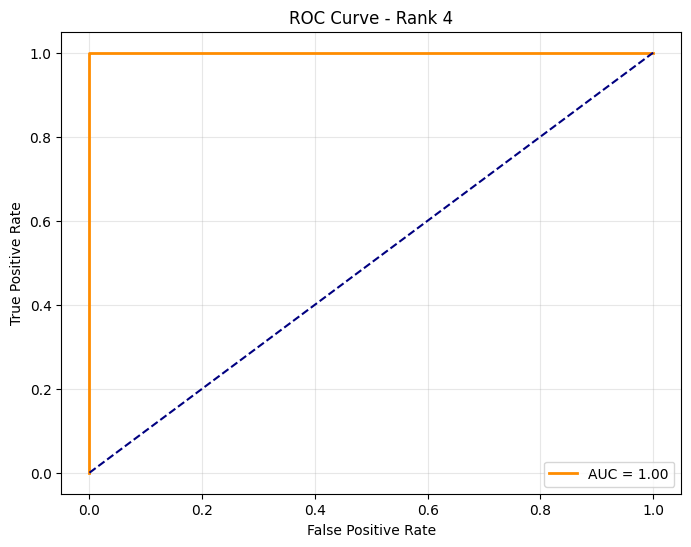

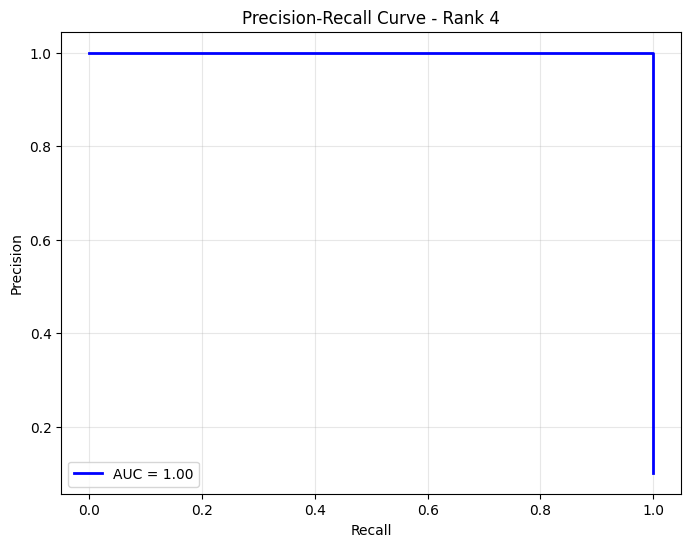


=== Rank 5 ===
error= tensor(0.1404, device='cuda:0')
error= 0.1403922587633133
✅ Projection completed.
Residual norm: 95258.75
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5687 - auc_5: 0.6225 - loss: 0.7525 - val_accuracy: 0.1215 - val_auc_5: 0.9778 - val_loss: 0.7752
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6857 - auc_5: 0.8811 - loss: 0.5734 - val_accuracy: 0.1213 - val_auc_5: 0.9884 - val_loss: 0.8228
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7747 - auc_5: 0.9615 - loss: 0.4554 - val_accuracy: 0.1210 - val_auc_5: 0.9870 - val_loss: 0.8381
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8378 - auc_5: 0.9649 - loss: 0.3942 - val_accuracy: 0.1213 - val_auc_5: 0.9894 - val_loss: 0.8425
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9027 - auc_5: 0.9923 - loss: 0.3144 - val_accuracy: 0.1216 -

<Figure size 600x500 with 0 Axes>

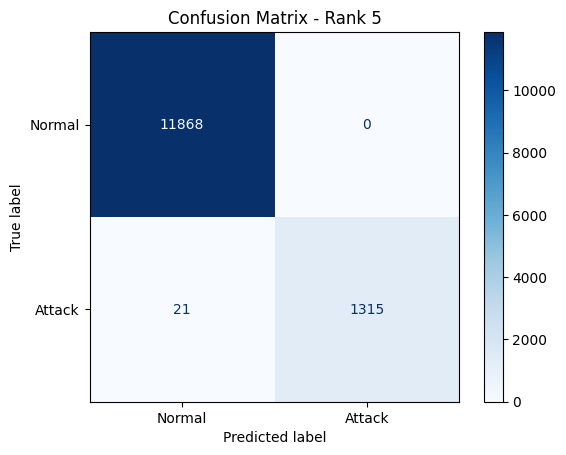

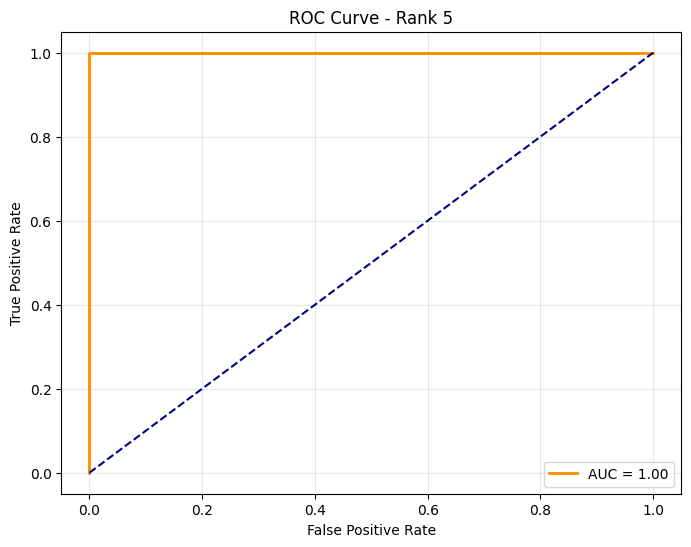

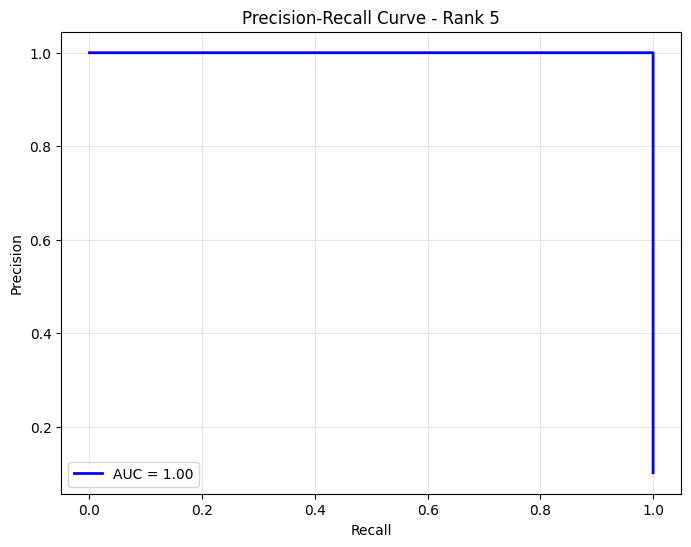


=== Rank 6 ===
error= tensor(0.1267, device='cuda:0')
error= 0.12671935558319092
✅ Projection completed.
Residual norm: 95256.9296875
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.6785 - auc_6: 0.9216 - loss: 0.5787 - val_accuracy: 0.9342 - val_auc_6: 0.9913 - val_loss: 0.6262
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7696 - auc_6: 0.9825 - loss: 0.4692 - val_accuracy: 0.9937 - val_auc_6: 1.0000 - val_loss: 0.6014
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8403 - auc_6: 0.9923 - loss: 0.3959 - val_accuracy: 0.9973 - val_auc_6: 1.0000 - val_loss: 0.5405
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8981 - auc_6: 0.9930 - loss: 0.3369 - val_accuracy: 0.9981 - val_auc_6: 1.0000 - val_loss: 0.4434
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9040 - auc_6: 0.9938 - loss: 0.3314 - val_accuracy: 0.9

<Figure size 600x500 with 0 Axes>

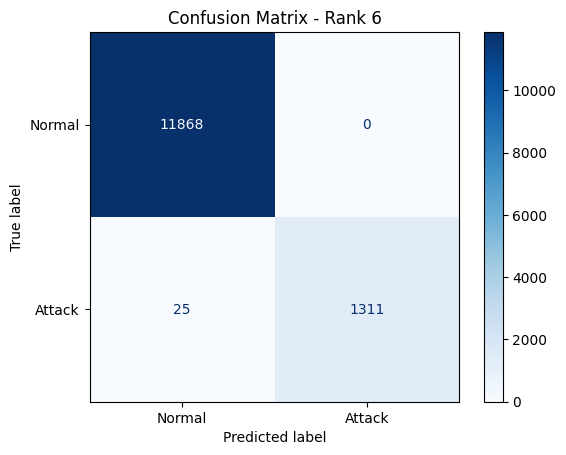

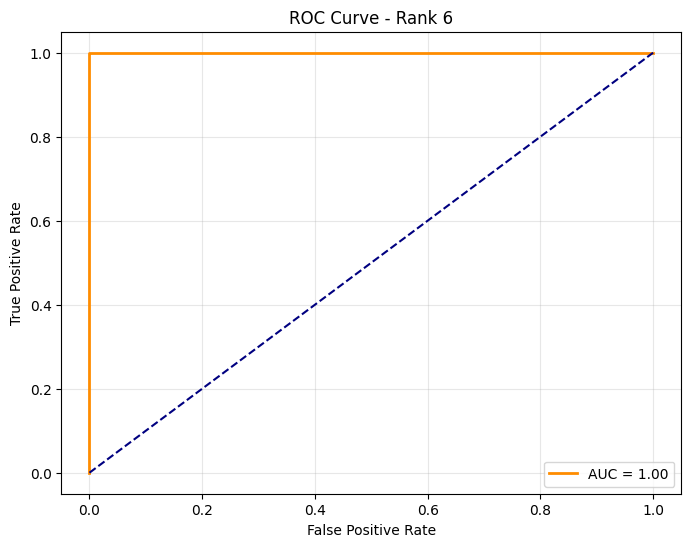

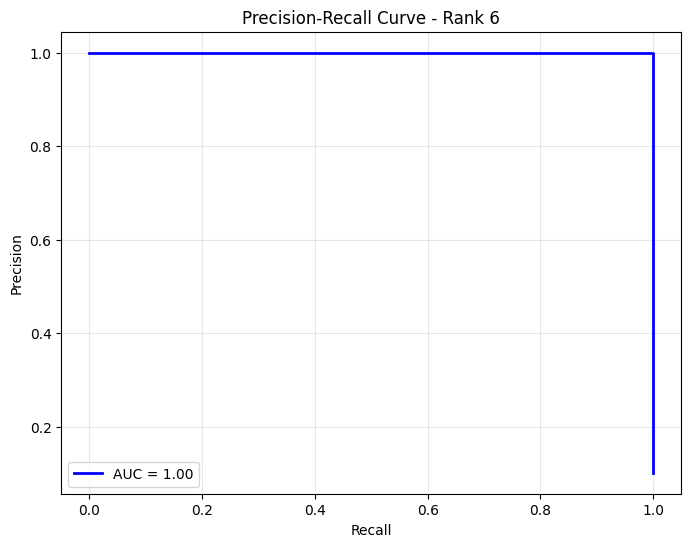


=== Rank 7 ===
error= tensor(0.1235, device='cuda:0')
error= 0.12353095412254333
✅ Projection completed.
Residual norm: 95257.9765625
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5617 - auc_7: 0.6767 - loss: 0.7521 - val_accuracy: 0.1223 - val_auc_7: 0.9981 - val_loss: 0.7549
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7253 - auc_7: 0.9052 - loss: 0.5473 - val_accuracy: 0.1222 - val_auc_7: 0.9981 - val_loss: 0.8326
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8200 - auc_7: 0.9854 - loss: 0.4129 - val_accuracy: 0.1222 - val_auc_7: 0.9981 - val_loss: 0.8860
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8821 - auc_7: 0.9888 - loss: 0.3563 - val_accuracy: 0.1219 - val_auc_7: 0.9952 - val_loss: 0.8844
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9031 - auc_7: 0.9981 - loss: 0.3234 - val_accuracy: 0.

<Figure size 600x500 with 0 Axes>

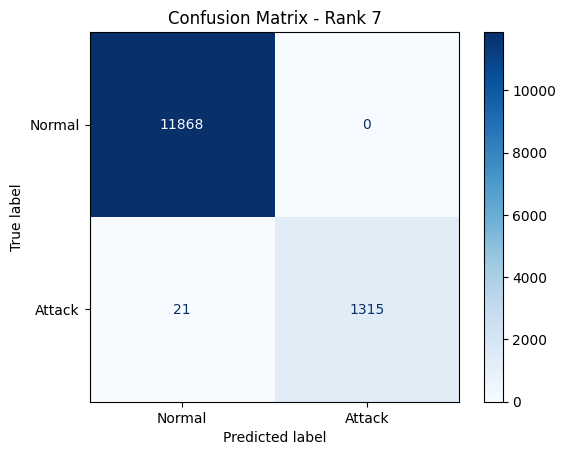

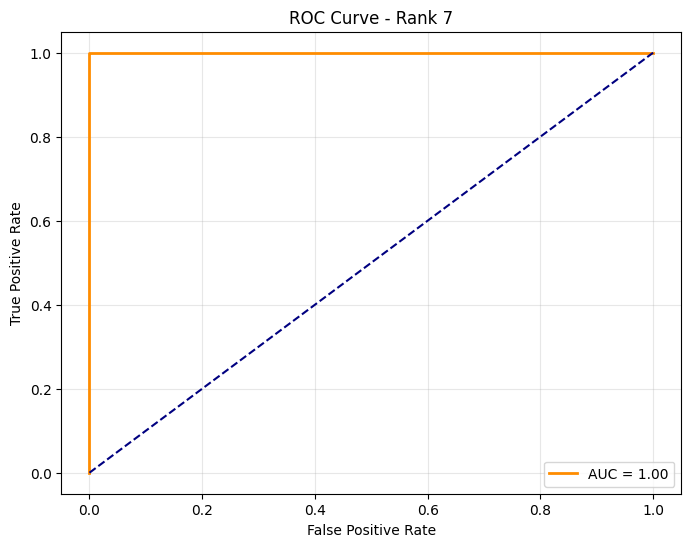

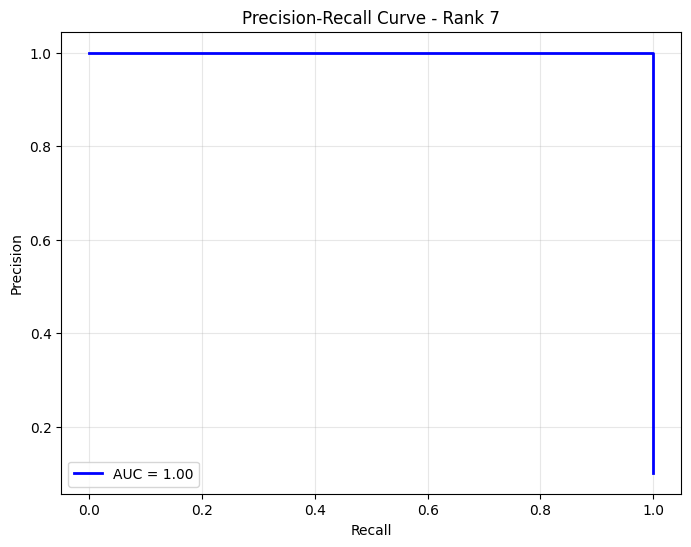


=== Rank 8 ===
error= tensor(0.1132, device='cuda:0')
error= 0.11321435123682022
✅ Projection completed.
Residual norm: 95258.921875
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4849 - auc_8: 0.3879 - loss: 0.9395 - val_accuracy: 0.8813 - val_auc_8: 0.8556 - val_loss: 0.5450
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6271 - auc_8: 0.7576 - loss: 0.6782 - val_accuracy: 0.8916 - val_auc_8: 0.9884 - val_loss: 0.4858
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7509 - auc_8: 0.9190 - loss: 0.5235 - val_accuracy: 0.9392 - val_auc_8: 0.9952 - val_loss: 0.4524
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8130 - auc_8: 0.9531 - loss: 0.4576 - val_accuracy: 0.9944 - val_auc_8: 0.9957 - val_loss: 0.4299
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8671 - auc_8: 0.9736 - loss: 0.3951 - val_accuracy: 0.9

<Figure size 600x500 with 0 Axes>

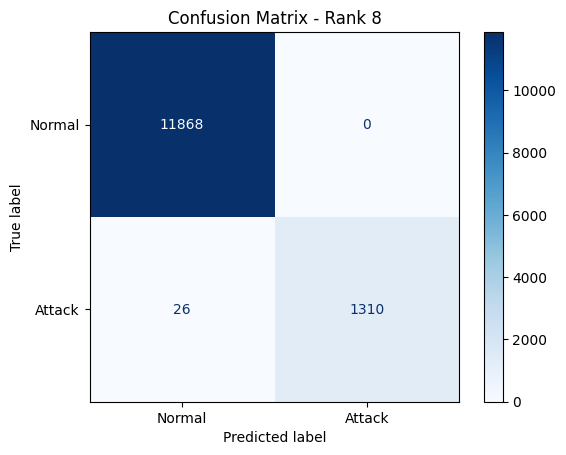

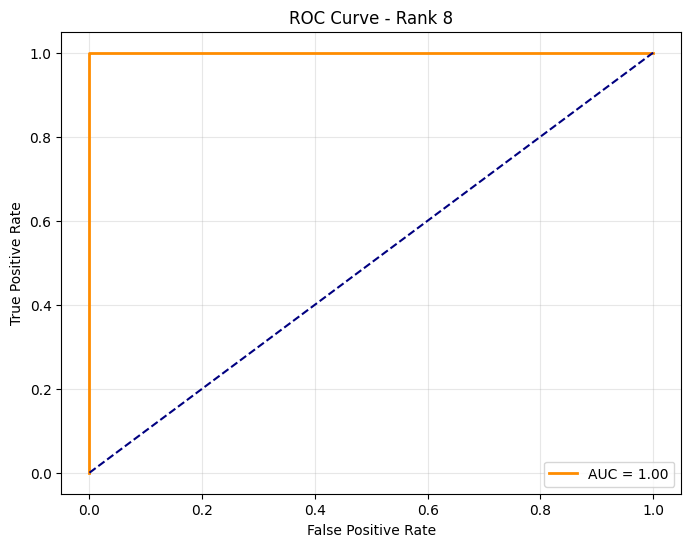

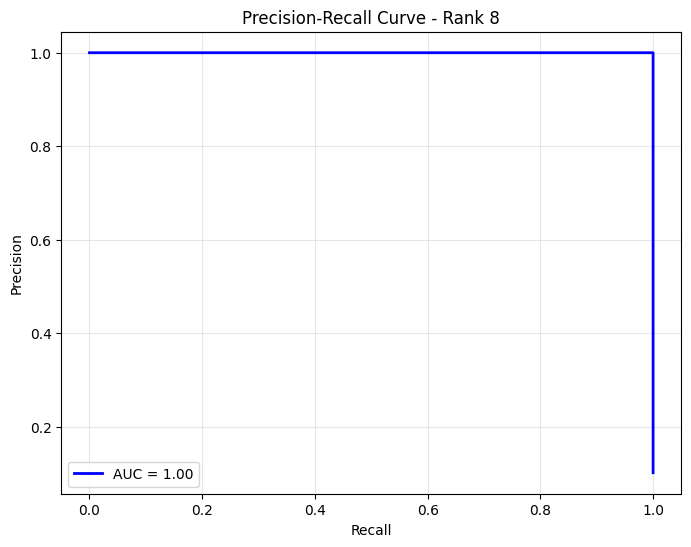


=== Rank 9 ===
error= tensor(0.1111, device='cuda:0')
error= 0.11111277341842651
✅ Projection completed.
Residual norm: 95256.328125
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4674 - auc_9: 0.4563 - loss: 0.8917 - val_accuracy: 0.1203 - val_auc_9: 0.7957 - val_loss: 0.7414
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6314 - auc_9: 0.8195 - loss: 0.6646 - val_accuracy: 0.1220 - val_auc_9: 0.9947 - val_loss: 0.8327
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6796 - auc_9: 0.8981 - loss: 0.5801 - val_accuracy: 0.1220 - val_auc_9: 0.9971 - val_loss: 0.9136
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7453 - auc_9: 0.9560 - loss: 0.4906 - val_accuracy: 0.1220 - val_auc_9: 0.9961 - val_loss: 0.9546
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8094 - auc_9: 0.9773 - loss: 0.4265 - val_accuracy: 0.1

<Figure size 600x500 with 0 Axes>

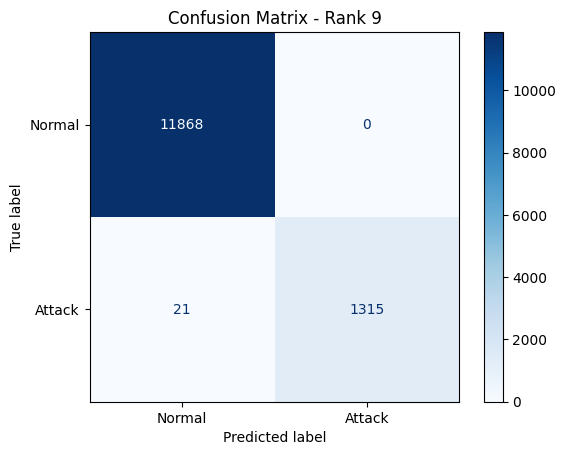

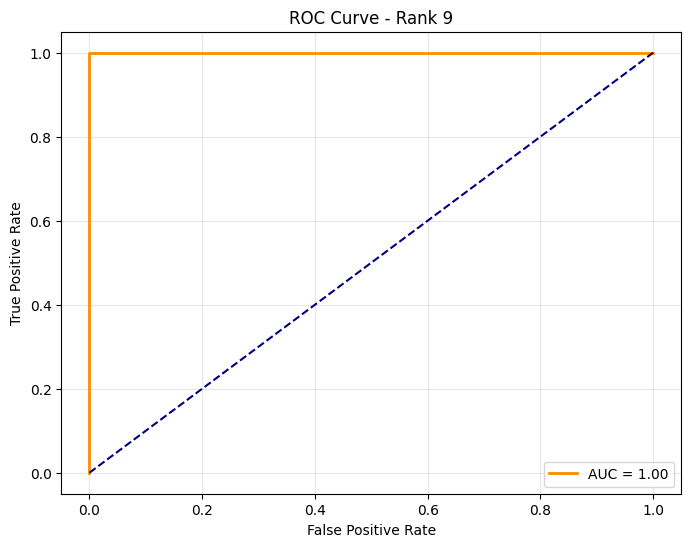

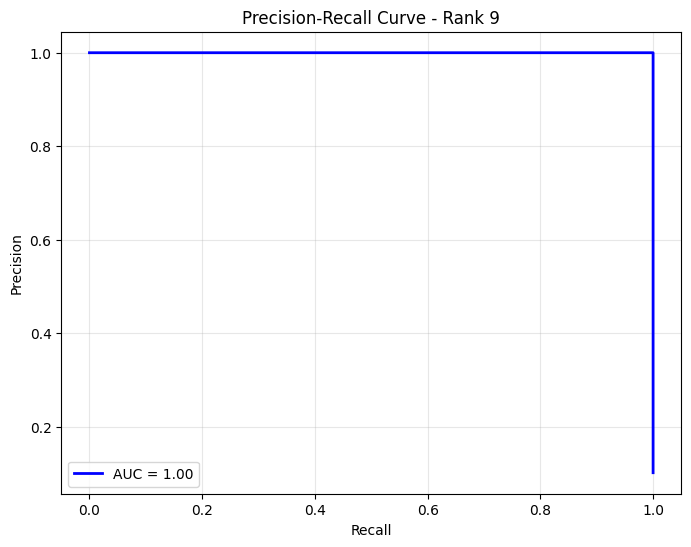


=== Rank 10 ===
error= tensor(0.1191, device='cuda:0')
error= 0.11907370388507843
✅ Projection completed.
Residual norm: 95258.9296875
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5781 - auc_10: 0.6440 - loss: 0.7250 - val_accuracy: 0.8811 - val_auc_10: 0.9913 - val_loss: 0.5789
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7449 - auc_10: 0.9004 - loss: 0.5309 - val_accuracy: 0.8887 - val_auc_10: 0.9986 - val_loss: 0.5228
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8274 - auc_10: 0.9613 - loss: 0.4528 - val_accuracy: 0.9134 - val_auc_10: 0.9990 - val_loss: 0.4915
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8941 - auc_10: 0.9888 - loss: 0.3879 - val_accuracy: 0.9917 - val_auc_10: 1.0000 - val_loss: 0.4504
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9304 - auc_10: 0.9939 - loss: 0.3379 - val_acc

<Figure size 600x500 with 0 Axes>

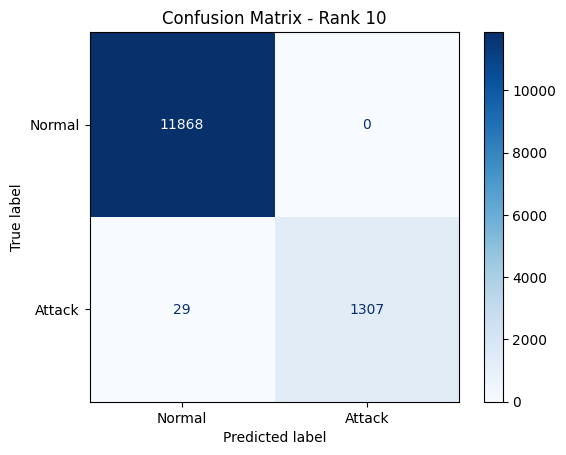

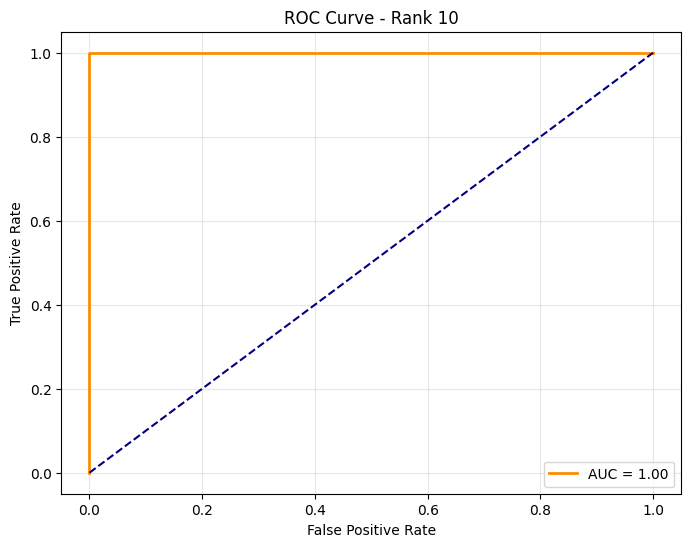

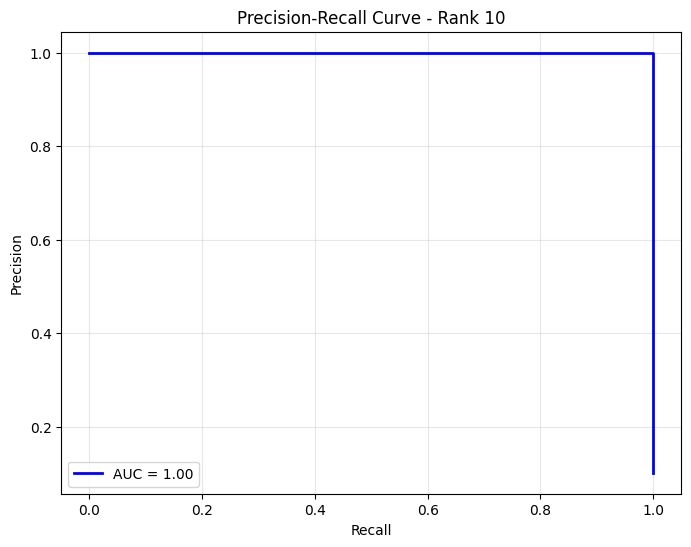


=== Rank 11 ===
error= tensor(0.1067, device='cuda:0')
error= 0.1067320927977562
✅ Projection completed.
Residual norm: 95255.734375
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.4851 - auc_11: 0.3846 - loss: 0.8734 - val_accuracy: 0.8854 - val_auc_11: 0.9836 - val_loss: 0.6312
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6098 - auc_11: 0.7153 - loss: 0.6677 - val_accuracy: 0.9937 - val_auc_11: 0.9990 - val_loss: 0.6200
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7262 - auc_11: 0.8960 - loss: 0.5481 - val_accuracy: 0.9989 - val_auc_11: 0.9981 - val_loss: 0.6315
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7910 - auc_11: 0.9459 - loss: 0.4713 - val_accuracy: 0.9989 - val_auc_11: 0.9990 - val_loss: 0.5975
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8543 - auc_11: 0.9858 - loss: 0.3966 - val_accur

<Figure size 600x500 with 0 Axes>

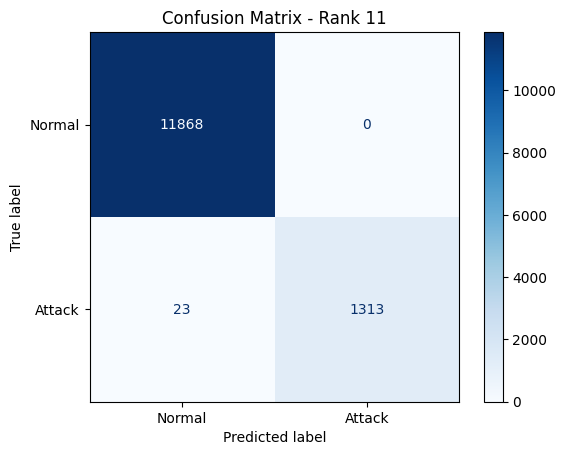

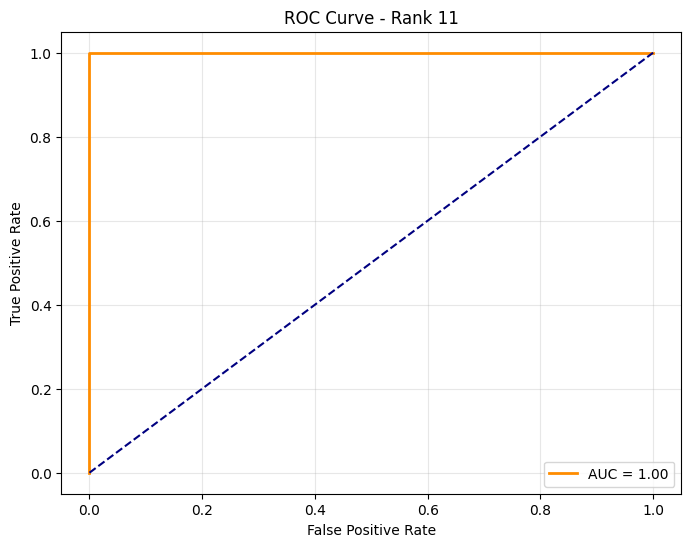

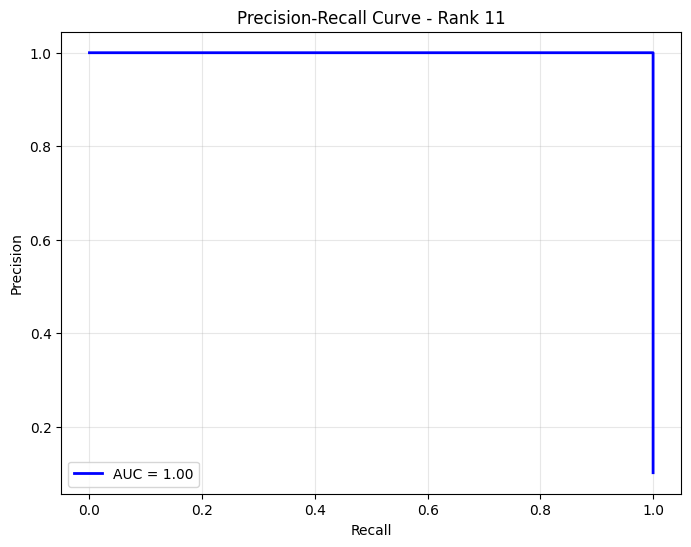


=== Rank 12 ===
error= tensor(0.1025, device='cuda:0')
error= 0.10252633690834045
✅ Projection completed.
Residual norm: 95258.4765625
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6426 - auc_12: 0.7892 - loss: 0.6440 - val_accuracy: 0.9016 - val_auc_12: 0.9860 - val_loss: 0.6017
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8053 - auc_12: 0.9534 - loss: 0.4852 - val_accuracy: 0.9570 - val_auc_12: 0.9990 - val_loss: 0.5506
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8180 - auc_12: 0.9857 - loss: 0.4589 - val_accuracy: 0.9936 - val_auc_12: 1.0000 - val_loss: 0.5133
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9151 - auc_12: 0.9932 - loss: 0.3698 - val_accuracy: 0.9967 - val_auc_12: 0.9971 - val_loss: 0.4813
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9480 - auc_12: 0.9966 - loss: 0.3289 - val_a

<Figure size 600x500 with 0 Axes>

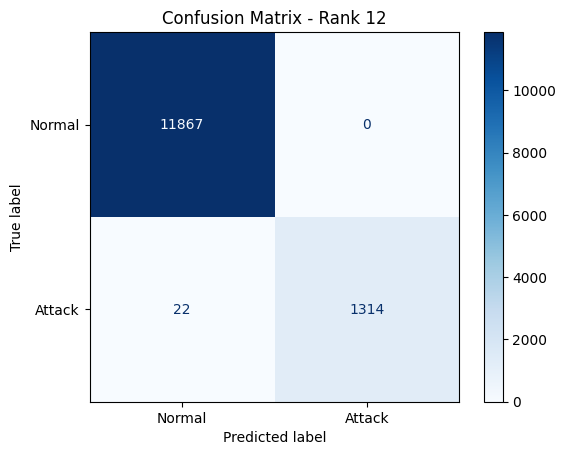

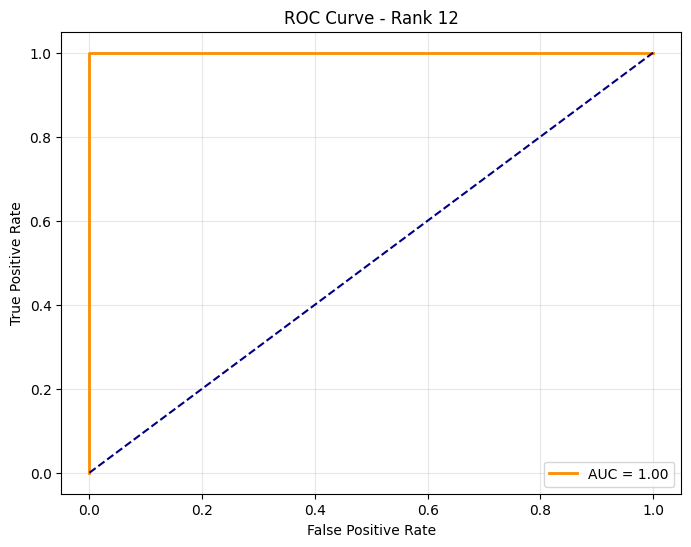

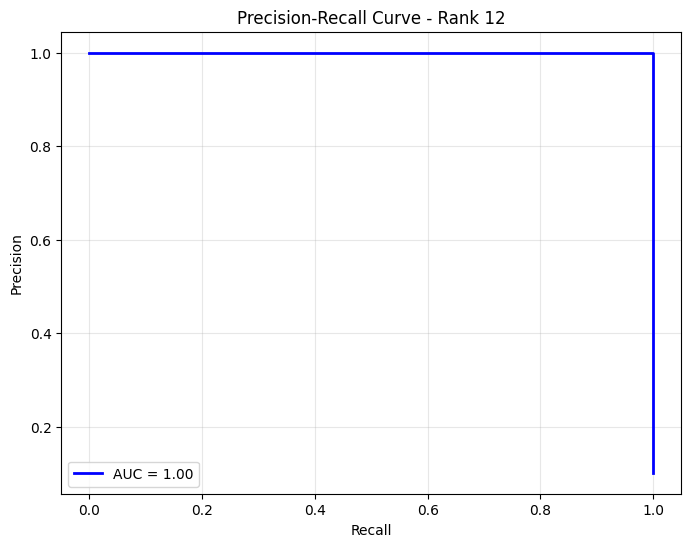


=== Rank 13 ===
error= tensor(0.0988, device='cuda:0')
error= 0.09884154051542282
✅ Projection completed.
Residual norm: 95258.03125
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5172 - auc_13: 0.5619 - loss: 0.7827 - val_accuracy: 0.9561 - val_auc_13: 0.9362 - val_loss: 0.6722
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6561 - auc_13: 0.8189 - loss: 0.6033 - val_accuracy: 0.9915 - val_auc_13: 0.9802 - val_loss: 0.6367
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7781 - auc_13: 0.9520 - loss: 0.4966 - val_accuracy: 0.9947 - val_auc_13: 0.9836 - val_loss: 0.5830
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8064 - auc_13: 0.9585 - loss: 0.4528 - val_accuracy: 0.9966 - val_auc_13: 0.9865 - val_loss: 0.5291
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8658 - auc_13: 0.9883 - loss: 0.3903 - val_accur

<Figure size 600x500 with 0 Axes>

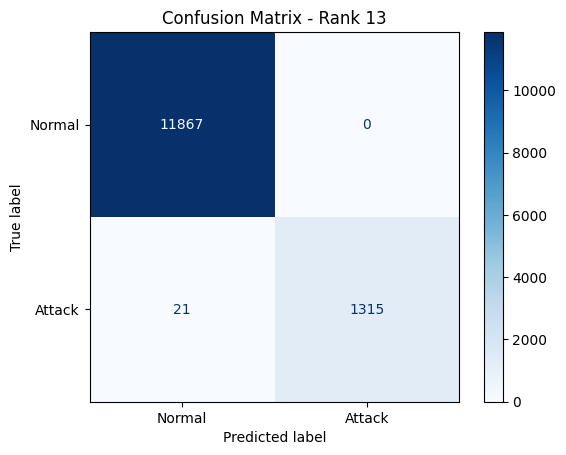

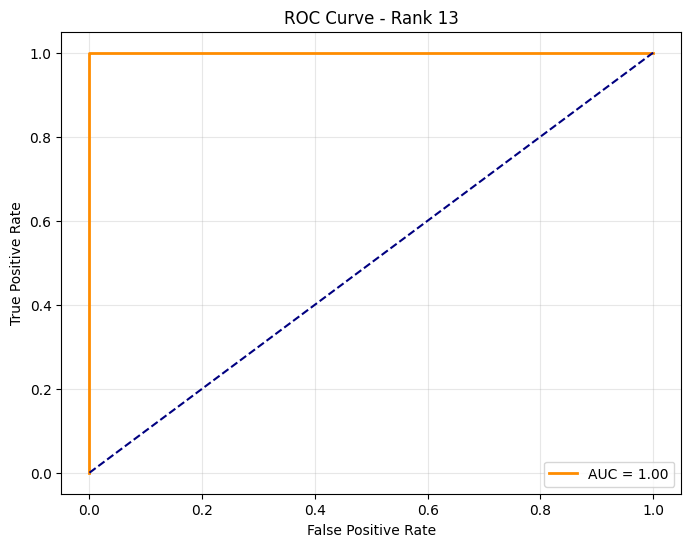

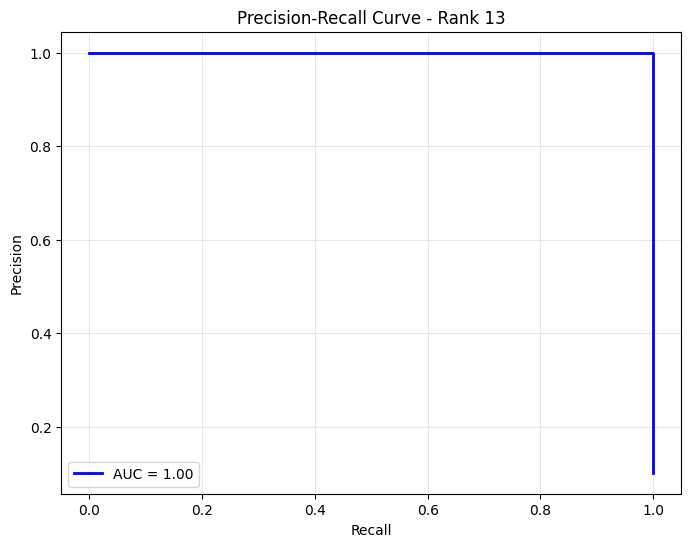


=== Rank 14 ===
error= tensor(0.0987, device='cuda:0')
error= 0.0987103283405304
✅ Projection completed.
Residual norm: 95256.40625
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6818 - auc_14: 0.9216 - loss: 0.6180 - val_accuracy: 0.9957 - val_auc_14: 1.0000 - val_loss: 0.6337
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7991 - auc_14: 0.9886 - loss: 0.4543 - val_accuracy: 0.9986 - val_auc_14: 0.9990 - val_loss: 0.6002
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8620 - auc_14: 0.9962 - loss: 0.3706 - val_accuracy: 0.9991 - val_auc_14: 0.9990 - val_loss: 0.5619
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8792 - auc_14: 0.9906 - loss: 0.3444 - val_accuracy: 0.9991 - val_auc_14: 0.9990 - val_loss: 0.4920
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9252 - auc_14: 0.9989 - loss: 0.2939 - val_accura

<Figure size 600x500 with 0 Axes>

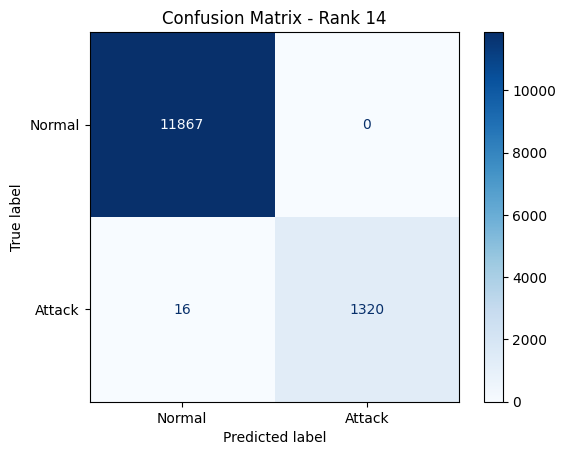

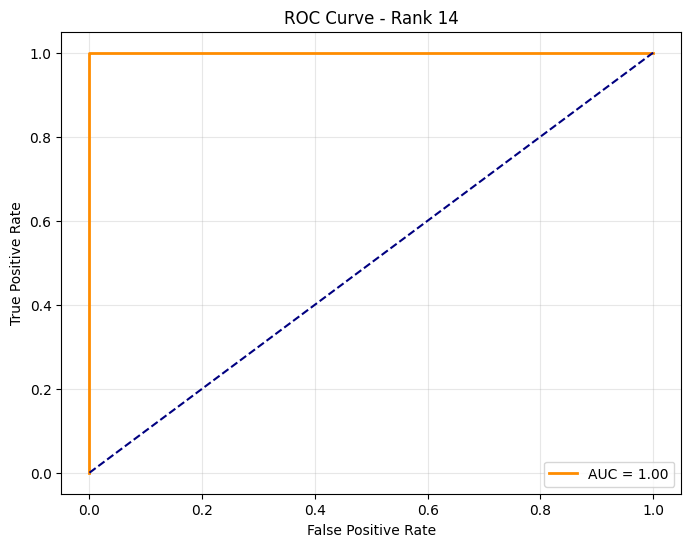

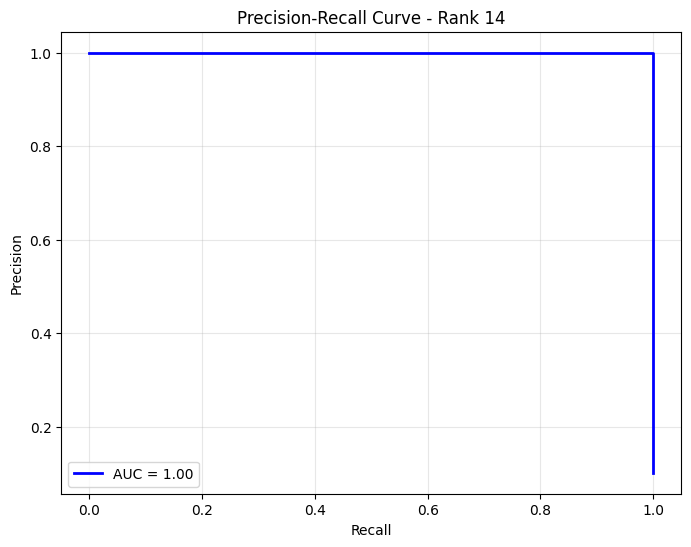


=== Rank 15 ===
error= tensor(0.0884, device='cuda:0')
error= 0.08842223137617111
✅ Projection completed.
Residual norm: 95255.7578125
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5679 - auc_15: 0.6664 - loss: 0.7430 - val_accuracy: 0.1224 - val_auc_15: 0.9947 - val_loss: 0.7006
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6986 - auc_15: 0.8924 - loss: 0.5546 - val_accuracy: 0.1224 - val_auc_15: 1.0000 - val_loss: 0.6760
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7893 - auc_15: 0.9649 - loss: 0.4552 - val_accuracy: 0.9991 - val_auc_15: 0.9990 - val_loss: 0.6240
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8396 - auc_15: 0.9787 - loss: 0.4078 - val_accuracy: 0.9986 - val_auc_15: 1.0000 - val_loss: 0.5223
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8922 - auc_15: 0.9954 - loss: 0.3558 - val_ac

<Figure size 600x500 with 0 Axes>

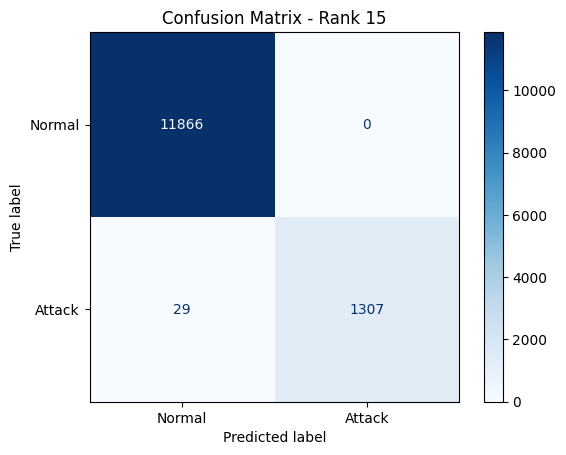

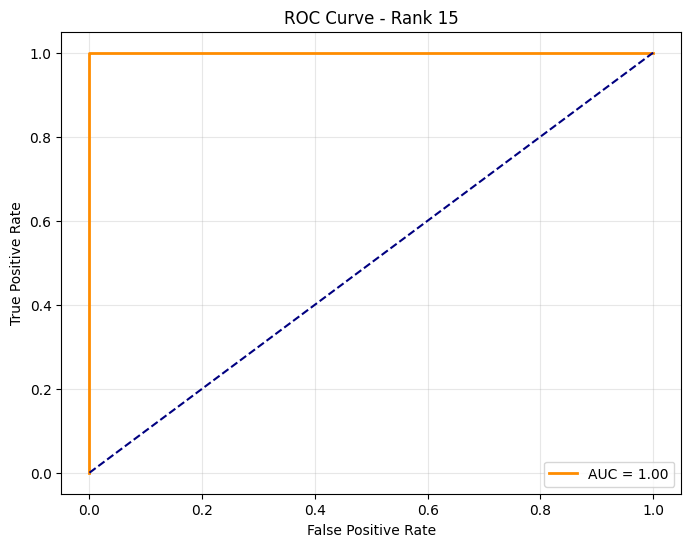

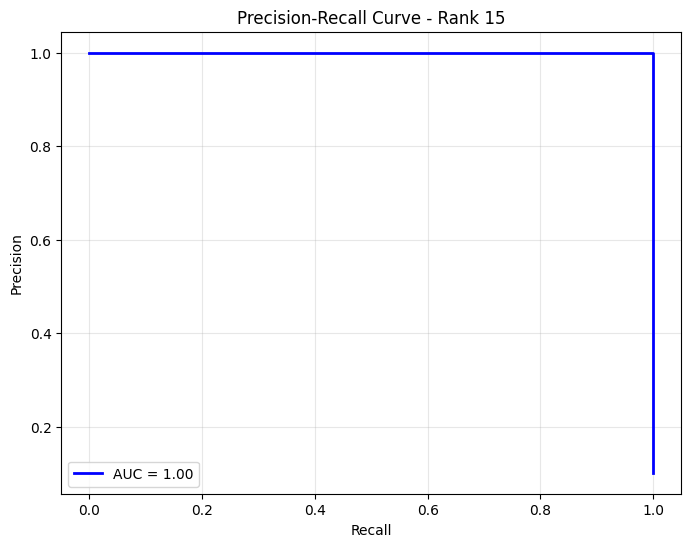


=== Rank 16 ===
error= tensor(0.0863, device='cuda:0')
error= 0.08633315563201904
✅ Projection completed.
Residual norm: 95256.1796875
⏳ Step 4: Aggregating scores with labels...
✅ Score aggregation + labeling completed.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5741 - auc_16: 0.6439 - loss: 0.7561 - val_accuracy: 0.8919 - val_auc_16: 0.9357 - val_loss: 0.6523
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7224 - auc_16: 0.9075 - loss: 0.5329 - val_accuracy: 0.9876 - val_auc_16: 0.9865 - val_loss: 0.6219
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8108 - auc_16: 0.9598 - loss: 0.4236 - val_accuracy: 0.9961 - val_auc_16: 0.9971 - val_loss: 0.5934
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8710 - auc_16: 0.9814 - loss: 0.3492 - val_accuracy: 0.9983 - val_auc_16: 1.0000 - val_loss: 0.5629
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9197 - auc_16: 0.9917 - loss: 0.2908 - val_acc

<Figure size 600x500 with 0 Axes>

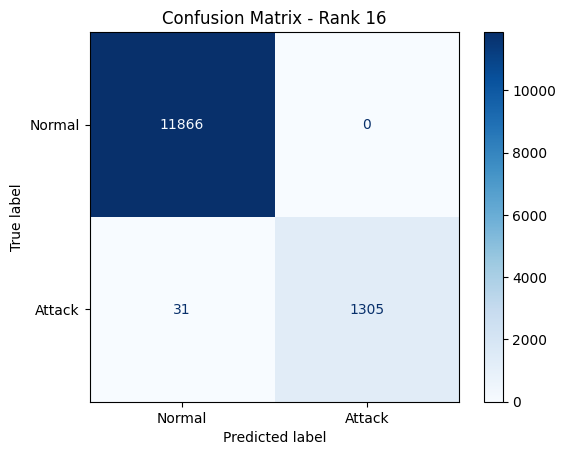

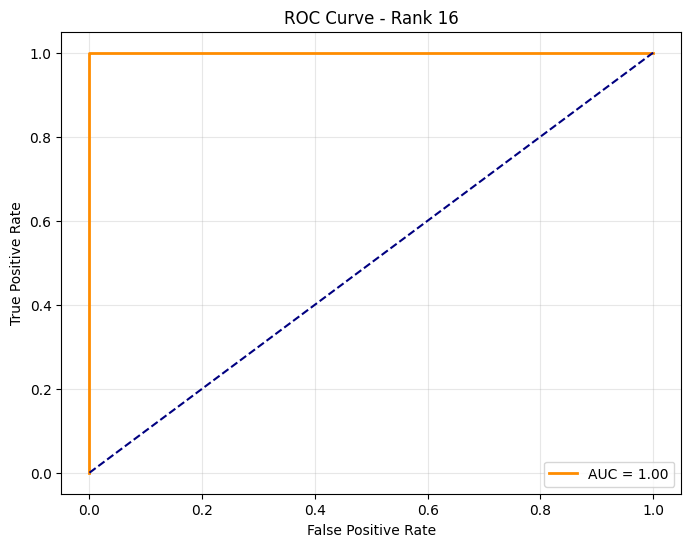

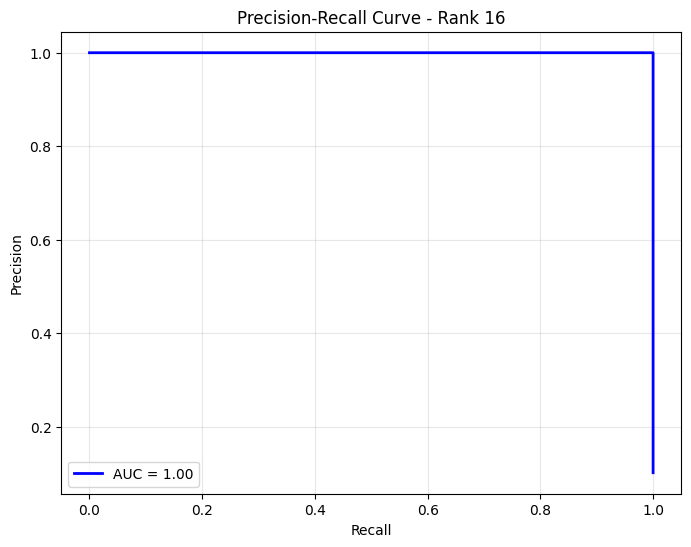

In [39]:
# Initialize lists
error_list = []
cm_list = []
model_results = []
model_list = []
df_test_list = []

# Loop over CP ranks from 1 to 20
for rank in range(1, 17):
    print(f"\n=== Rank {rank} ===")

    # 1. Tensor Normal Decomposition
    factors_normal, error = Tensor_decomposition(tensor_normal, rank)
    error_list.append(error)

    # 2. Residuals on Training Tensor
    residuals_train = normal_space_projection(tensor_train, factors_normal)

    # 3. Score Aggregation (Train)
    df_scores_train = aggregation_scoring_Source(residuals_train, mappings, df_train, window_size=300)

    # 4. Outlier Removal (Train)
    df = remove_outliers_iqr(df_scores_train[df_scores_train['label']==0], features)
    df_train_cleaned = pd.concat([df,df_scores_train[df_scores_train['label']==1]],axis=0)

    # 5. Feature Extraction and Scaling
    s = StandardScaler()
    X1 = s.fit_transform(df_train_cleaned.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y1 = df_train_cleaned['label']

    # 6. Train/Test Split and Model Training
    #I have used all the data for training because the testing will be done using an other dataset so I just took 1% of the training set for vaalidation
    X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.7, random_state=42,stratify=Y1)
    model, history = build_and_train_binary_classifier(
        X_train, y_train, X_test, y_test,
        learning_rate=0.0001, batch_size=32, epochs=50
    )
    model_list.append(model)

    # 7. Residuals on Test Tensor
    residuals_test = normal_space_projection(tensor_test, factors_normal)
    df_scores_test = aggregation_scoring_Source(residuals_test, mappings, df_test, window_size=300)
    df_test_list.append(df_scores_test)
    # 8. Outlier Removal (Test)
    df1 = remove_outliers_iqr(df_scores_test[df_scores_test['label']==0], features)
    df_test_cleaned = pd.concat([df1,df_scores_test[df_scores_test['label']==1]],axis=0)

    # 9. Feature Scaling (Use fitted scaler from train)
    X = s.transform(df_test_cleaned.drop(columns=['label', 'Dst IP', 'time_windows']))
    Y = df_test_cleaned['label']

    # 10. Prediction
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # 11. Evaluation Metrics
    accuracy = accuracy_score(Y, y_pred)
    precision = precision_score(Y, y_pred)
    recall = recall_score(Y, y_pred)
    f1 = f1_score(Y, y_pred)

    model_results.append({
        'Model': f'Model_{rank}',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

    # 12. Confusion Matrix
    cm = confusion_matrix(Y, y_pred)
    cm_list.append(cm)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Rank {rank}')
    plt.show()

    # 13. ROC Curve
    fpr, tpr, _ = roc_curve(Y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Rank {rank}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 14. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(Y, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Rank {rank}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Model Comparison Results:
       Model  Accuracy  Precision  Recall  F1_Score
0    Model_1    0.9980        1.0  0.9805    0.9902
1    Model_2    0.9974        1.0  0.9746    0.9871
2    Model_3    0.9983        1.0  0.9828    0.9913
3    Model_4    0.9984        1.0  0.9843    0.9921
4    Model_5    0.9984        1.0  0.9843    0.9921
5    Model_6    0.9981        1.0  0.9813    0.9906
6    Model_7    0.9984        1.0  0.9843    0.9921
7    Model_8    0.9980        1.0  0.9805    0.9902
8    Model_9    0.9984        1.0  0.9843    0.9921
9   Model_10    0.9978        1.0  0.9783    0.9890
10  Model_11    0.9983        1.0  0.9828    0.9913
11  Model_12    0.9983        1.0  0.9835    0.9917
12  Model_13    0.9984        1.0  0.9843    0.9921
13  Model_14    0.9988        1.0  0.9880    0.9940
14  Model_15    0.9978        1.0  0.9783    0.9890
15  Model_16    0.9977        1.0  0.9768    0.9883


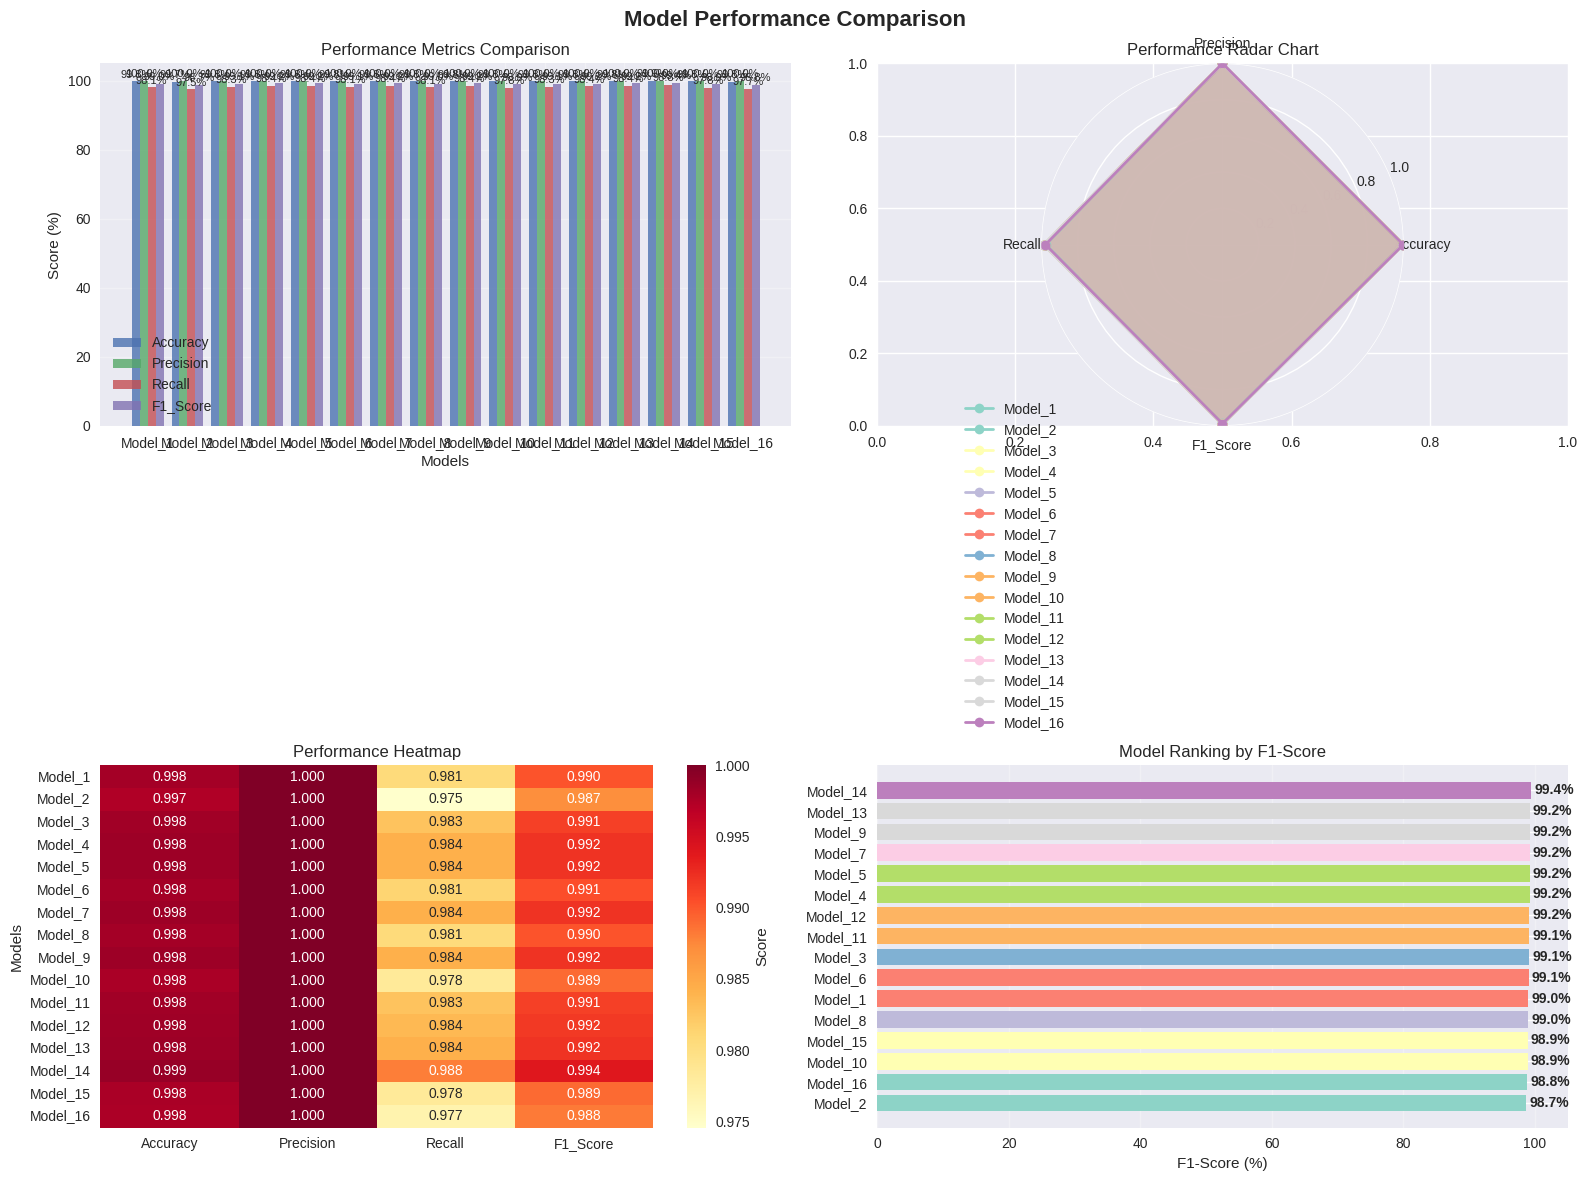


FINAL PERFORMANCE SUMMARY
   Model Accuracy Precision Recall F1_Score
 Model_1    99.8%    100.0% 98.05%   99.02%
 Model_2   99.74%    100.0% 97.46%   98.71%
 Model_3   99.83%    100.0% 98.28%   99.13%
 Model_4   99.84%    100.0% 98.43%   99.21%
 Model_5   99.84%    100.0% 98.43%   99.21%
 Model_6   99.81%    100.0% 98.13%   99.06%
 Model_7   99.84%    100.0% 98.43%   99.21%
 Model_8    99.8%    100.0% 98.05%   99.02%
 Model_9   99.84%    100.0% 98.43%   99.21%
Model_10   99.78%    100.0% 97.83%    98.9%
Model_11   99.83%    100.0% 98.28%   99.13%
Model_12   99.83%    100.0% 98.35%   99.17%
Model_13   99.84%    100.0% 98.43%   99.21%
Model_14   99.88%    100.0%  98.8%    99.4%
Model_15   99.78%    100.0% 97.83%    98.9%
Model_16   99.77%    100.0% 97.68%   98.83%

Best performing model: Model_14 with F1-Score: 0.994


In [40]:
# ====== IMPORTS & STYLE ======
plt.style.use('seaborn-v0_8')
colors = plt.cm.Set3(np.linspace(0, 1, 20))

# ====== CREATE COMPARISON TABLE ======
results_df = pd.DataFrame(model_results)
print("Model Comparison Results:")
print(results_df.round(4))

# ====== COMPARISON PLOTS ======
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Bar plot of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x = np.arange(len(results_df))
width = 0.2
ax1 = axes[0, 0]

for i, metric in enumerate(metrics):
    values = results_df[metric].values * 100
    bars = ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score (%)')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# 2. Radar chart
from math import pi
categories = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

ax2 = plt.subplot(2, 2, 2, projection='polar')
for i, model_name in enumerate(results_df['Model']):
    values = results_df.loc[i, categories].tolist() + [results_df.loc[i, categories[0]]]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax2.fill(angles, values, alpha=0.25, color=colors[i])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('Performance Radar Chart')
ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 3. Heatmap
ax3 = axes[1, 0]
heatmap_data = results_df.set_index('Model')[metrics]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=ax3, cbar_kws={'label': 'Score'})
ax3.set_title('Performance Heatmap')
ax3.set_ylabel('Models')

# 4. F1-score ranking
ax4 = axes[1, 1]
sorted_results = results_df.sort_values('F1_Score', ascending=True)
bars = ax4.barh(sorted_results['Model'], sorted_results['F1_Score'] * 100,
                color=colors[:len(sorted_results)])
for i, (idx, row) in enumerate(sorted_results.iterrows()):
    ax4.text(row['F1_Score'] * 100 + 0.5, i, f'{row["F1_Score"]*100:.1f}%',
             va='center', fontweight='bold')

ax4.set_xlabel('F1-Score (%)')
ax4.set_title('Model Ranking by F1-Score')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim(0, 105)

plt.tight_layout()
plt.show()

# ====== SUMMARY TABLE ======
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
summary_table = results_df.copy()
for col in metrics:
    summary_table[col] = (summary_table[col] * 100).round(2).astype(str) + '%'
print(summary_table.to_string(index=False))

# ====== BEST MODEL ======
best_model_idx = results_df['F1_Score'].idxmax()
best_model = results_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']} with F1-Score: {best_model['F1_Score']:.3f}")


**OTHER METHODS**

In [ ]:
nume_col=df_train.select_dtypes(include=['float64','int64']).columns
categorical_col=df_train.select_dtypes(include=['object']).columns
time_col=df_train.select_dtypes(include=['datetime64']).columns

In [ ]:
df_train['hour'] = df_train['relative_time'].dt.components['hours']
df_train['minute'] = df_train['relative_time'].dt.components['minutes']
df_train['second'] = df_train['relative_time'].dt.components['seconds']

In [ ]:
df_train=df_train.drop(columns=['relative_time','hour'],axis=1)

In [ ]:
df_train.drop(columns=categorical_col, inplace=True)

In [ ]:
nume_col = nume_col.append(pd.Index(['minute', 'second']))

In [ ]:
df=df_train[nume_col]

In [ ]:
df_train_clain_0=remove_outliers_iqr(df[df['label']==0],nume_col)

In [ ]:
df_train_clain_1=pd.concat([df[df['label']==1],df_train_clain_0],axis=0)

In [ ]:
Scale=StandardScaler()

In [ ]:
X=Scale.fit_transform(df_train_clain_1.drop(columns=['label']))
Y=df_train_clain_1['label']

In [ ]:
# X_train, y_train, X_test, y_test = train_test_split(X, Y, test_size=0.001, random_state=42,stratify=Y) # Original incorrect line

# Correct assignment
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=42,stratify=Y)

In [ ]:
df_train_clain_0.shape

(2190, 82)

** RANDOM FOREST**

Accuracy: 0.9992507492507493

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       1.00      1.00      1.00      3982

    accuracy                           1.00      4004
   macro avg       0.96      0.98      0.97      4004
weighted avg       1.00      1.00      1.00      4004



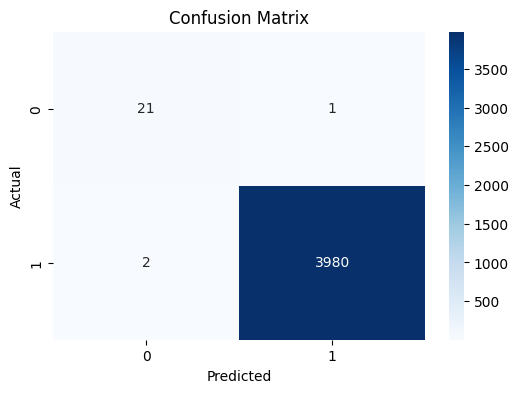

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
df_test['hour'] = df_test['relative_time'].dt.components['hours']
df_test['minute'] = df_test['relative_time'].dt.components['minutes']
df_test['second'] = df_test['relative_time'].dt.components['seconds']

In [ ]:
df_test_clain_0=remove_outliers_iqr(df_test[nume_col][df_test[nume_col]['label']==0],nume_col)

In [ ]:
df_test_clain_1=pd.concat([df_test[df_test['label']==1],df_test_clain_0],axis=0)

In [ ]:
X1=Scale.transform(df_test[nume_col].drop('label',axis=1))
Y1=df_test['label']

✅ Accuracy: 0.8763
🎯 Precision: 0.8857
🔁 Recall: 0.8763
📊 F1 Score: 0.8315

📄 Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.11      0.20     11719
           1       0.88      1.00      0.93     72990

    accuracy                           0.88     84709
   macro avg       0.91      0.56      0.57     84709
weighted avg       0.89      0.88      0.83     84709



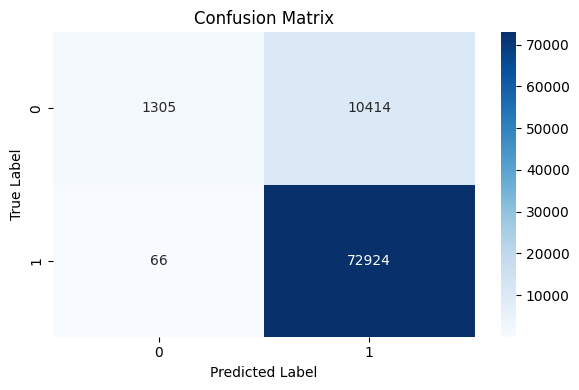

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
y_pred = model.predict(X1)

# Évaluation détaillée
accuracy = accuracy_score(Y1, y_pred)
precision = precision_score(Y1, y_pred, average='weighted')
recall = recall_score(Y1, y_pred, average='weighted')
f1 = f1_score(Y1, y_pred, average='weighted')

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall: {recall:.4f}")
print(f"📊 F1 Score: {f1:.4f}")

# Rapport complet
print("\n📄 Classification Report:\n")
print(classification_report(Y1, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(Y1, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
